## 0. Importing PyTorch and setting up device-agnostic code

In [66]:
# rm -rf data
# rm -rf models

In [67]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [68]:
!nvidia-smi

Tue Jun  6 18:15:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    39W / 300W |   1984MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get Data

In [69]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it.
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} directory doesn't exist... creating one")
  image_path.mkdir(parents = True,
           exist_ok = True)
  
# Download pizza, steak, and sushi data
with open(data_path / "data.zip", "wb") as f:  
  request = requests.get("https://github.com/TC-PG/DL_Final_Project/raw/main/data/data.zip")
  print("Downloading data.zip...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "data.zip", "r") as zip_ref:
  print("Unzipping data.zip...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
Unzipping data.zip...


## 2. Data preparation and data exploration

In [70]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"Threre are {len(dirnames)} directories and {len(filenames)} images in {dir_path}")

walk_through_dir(image_path)

Threre are 2 directories and 0 images in data/pizza_steak_sushi
Threre are 10 directories and 0 images in data/pizza_steak_sushi
Threre are 0 directories and 250 images in data/pizza_steak_sushi
Threre are 0 directories and 250 images in data/pizza_steak_sushi
Threre are 0 directories and 250 images in data/pizza_steak_sushi
Threre are 0 directories and 250 images in data/pizza_steak_sushi
Threre are 0 directories and 250 images in data/pizza_steak_sushi
Threre are 0 directories and 250 images in data/pizza_steak_sushi
Threre are 0 directories and 250 images in data/pizza_steak_sushi
Threre are 0 directories and 250 images in data/pizza_steak_sushi
Threre are 0 directories and 250 images in data/pizza_steak_sushi
Threre are 0 directories and 250 images in data/pizza_steak_sushi
Threre are 10 directories and 0 images in data/pizza_steak_sushi
Threre are 0 directories and 750 images in data/pizza_steak_sushi
Threre are 0 directories and 750 images in data/pizza_steak_sushi
Threre are 0 d

In [71]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visulaizing and image

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class using `pathlib.Path.parent.stem`
4. open the image with Python's PIL
5. show the image and print metadata

Random image: data/pizza_steak_sushi/train/chicken_wings/980117.jpg
Random class: chicken_wings
Random height: 287
Random width: 512


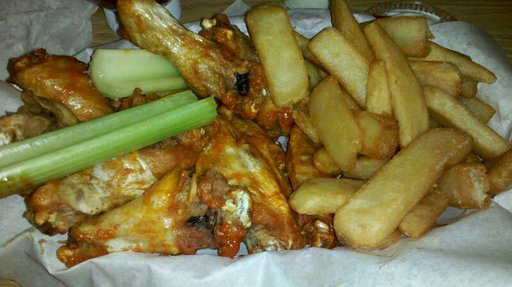

In [72]:
import random 
from PIL import Image

# 1. Get all of the images paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. open the image with Python's PIL
img = Image.open(random_image_path)

# 5. show the image and print metadata
print(f"Random image: {random_image_path}")
print(f"Random class: {image_class}")
print(f"Random height: {img.height}")
print(f"Random width: {img.width}")
img.show()

(-0.5, 511.5, 286.5, -0.5)

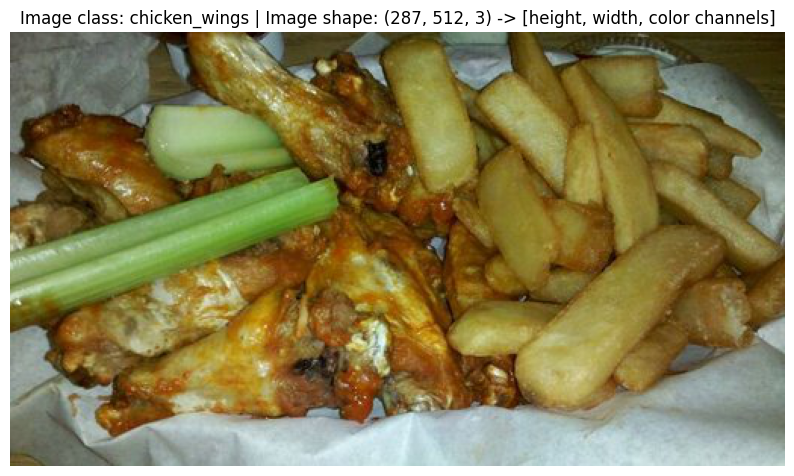

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize = (10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]")
plt.axis(False)

## 3. Create TinyVGG model class

In [74]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer
  """
  def __init__(self: int,
         input_shape: int,
         hidden_units: int,
         output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
             out_channels = hidden_units,
             kernel_size = 3,
             stride = 1,
             padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
             out_channels = hidden_units,
             kernel_size = 3,
             stride = 1,
             padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
               stride = 2) # default stride value is same as kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
             out_channels = hidden_units,
             kernel_size = 3,
             stride = 1,
             padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
             out_channels = hidden_units,
             kernel_size = 3,
             stride = 1,
             padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,
               stride = 2) # default stride value is same as kernel size
    )   
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 13 * 13,
             out_features = hidden_units)        
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"after conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"after conv_block_2: {x.shape}")   
    x = self.classifier(x)
    # print(f"after classifier: {x.shape}")
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

In [75]:
# model_2 = TinyVGG(input_shape = 3,
#           hidden_units = 20,
#           output_shape = 10).to(device)
# x = torch.randn(1,3,64,64)
# x
# y = model_2(x.to(device))

## 4. Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluate the model on the dataloader

In [76]:
# Create train_step() function
def train_step(model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device = device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):    
    X, y = X.to(device), y.to(device)

    y_pred = model(X) # output model logits

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Calculate accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)
  
  # Adjust metrics to get average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [77]:
# Create test_step()
def test_step(model: torch.nn.Module,
        dataloader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,        
        device = device):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_pred_logits = model(X_test)

      # calculate test loss
      loss = loss_fn(test_pred_logits, y_test)
      test_loss += loss.item()

      # calculate test accuracy
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim = 1), dim = 1)
      test_acc += (test_pred_labels == y_test).sum().item() / len(test_pred_labels)
    
    # Adjust metrics to get average test loss and test accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

### 5. Create a `train()` function to combine `train_step()` and `test_step()`

In [78]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
      train_dataloader: torch.utils.data.DataLoader,
      test_dataloader: torch.utils.data.DataLoader,        
      optimizer: torch.optim.Optimizer,  
      loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
      epochs: int = 5,
      device: torch.device = device):
  
  results = {"train_loss": [],
         "train_acc": [],
         "test_loss": [],
         "test_acc": []
        }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                       dataloader = train_dataloader,
                       loss_fn = loss_fn,
                       optimizer = optimizer,
                       device = device)
    
    test_loss, test_acc = test_step(model = model,
                      dataloader = test_dataloader,
                      loss_fn = loss_fn,                      
                      device = device)
    
    print(f"Epoch: {epoch} | Train loss: {train_loss: .4f} | Train accuracy: {train_acc * 100: .4f}% | Test loss: {test_loss: .4f} | Test accuracy: {test_acc * 100: .4f}%")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  return results

## 6. Create transform with data augmentation

In [79]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

## 7. Create train and test `Dataset`s and `DataLoader`s with data augmentation

In [80]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root = train_dir,
                       transform = train_transform_trivial, # a transform for the data
                       target_transform = None) # a transform for the label / target

test_data_simple = datasets.ImageFolder(root = test_dir,
                     transform = test_transform_simple,
                     target_transform=None)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 7500
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2500
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [81]:
# Get class names as list
class_names = train_data_augmented.classes
class_names

['chicken_wings',
 'donuts',
 'dumplings',
 'french_fries',
 'fried_rice',
 'pho',
 'pizza',
 'spaghetti_bolognese',
 'steak',
 'sushi']

In [82]:
# Get class names as dict
class_dict = train_data_augmented.class_to_idx
class_dict

{'chicken_wings': 0,
 'donuts': 1,
 'dumplings': 2,
 'french_fries': 3,
 'fried_rice': 4,
 'pho': 5,
 'pizza': 6,
 'spaghetti_bolognese': 7,
 'steak': 8,
 'sushi': 9}

In [83]:
# Check the lengths of dataset
len(train_data_augmented), len(test_data_simple)

(7500, 2500)

In [84]:
# X,y = train_data_augmented[0]
# X.shape, y

In [85]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset = train_data_augmented,
                     batch_size = BATCH_SIZE,
                     shuffle = True,
                     num_workers = NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset = test_data_simple,
                   batch_size = BATCH_SIZE,
                   shuffle = False,
                   num_workers = NUM_WORKERS)

train_data_augmented, test_dataloader_simple

(Dataset ImageFolder
     Number of datapoints: 7500
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 <torch.utils.data.dataloader.DataLoader at 0x7fcb4e8ba590>)

## 8. Construct and train model 

In [86]:
model_1 = TinyVGG(input_shape = 3,
          hidden_units = 10,
          output_shape = len(class_names)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=10, bias=True)
  )
)

### 8.1 Use `torchinfo` to get an idea of the shapes going through model

In [87]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_1, input_size = (1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [88]:
from timeit import default_timer as timer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                lr = 0.001)
EPOCHS = 1
start_time = timer()
model_1_results = train(model = model_1,
             train_dataloader = train_dataloader_augmented,
             test_dataloader = test_dataloader_simple,
             optimizer = optimizer,
             loss_fn = loss_fn,
             epochs = EPOCHS,
             device = device)

end_time = timer()

print(f"Total training time: {end_time - start_time: .3f} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0 | Train loss:  2.2980 | Train accuracy:  10.5403% | Test loss:  2.2189 | Test accuracy:  16.3281%
Total training time:  24.604 seconds


## 9. Plot the Loss Curves of Model

In [89]:
model_1_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [90]:
model_1_results

{'train_loss': [2.2979787992218794],
 'train_acc': [0.10540254237288135],
 'test_loss': [2.2189287185668944],
 'test_acc': [0.16328125]}

In [91]:
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  
  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize = (15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label = "train_accuracy")
  plt.plot(epochs, test_accuracy, label = "test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

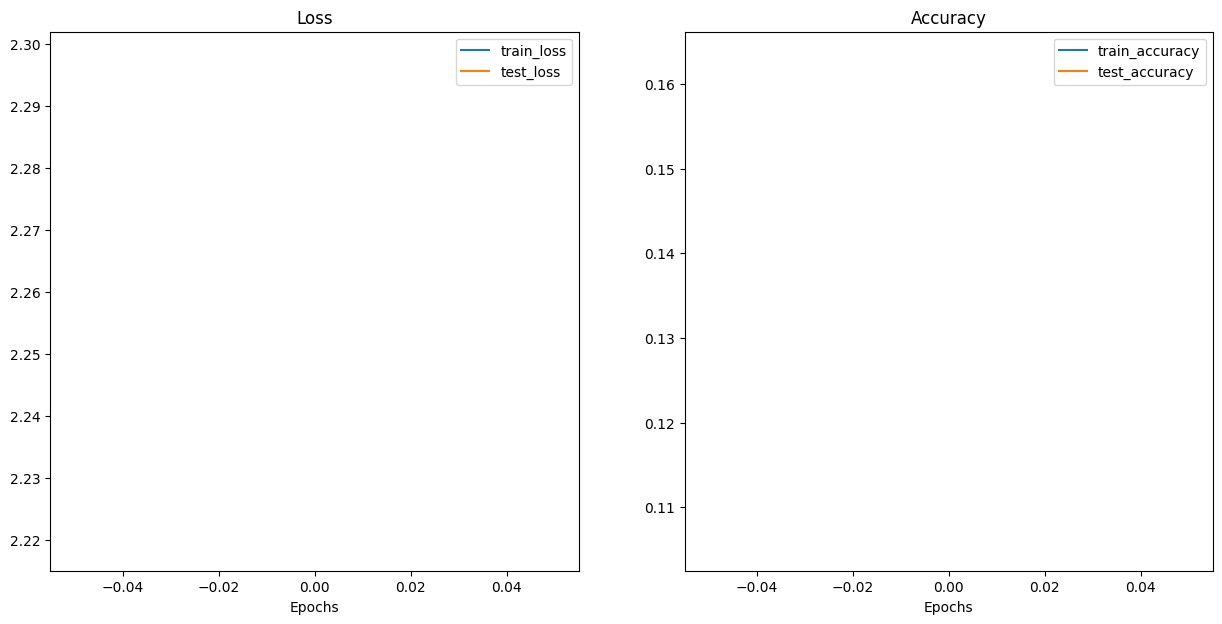

In [92]:
plot_loss_curves(model_1_results)

## 10. Save and load a model

In [93]:
from pathlib import Path

# Create model directory path
# MODEL_PATH = Path("models")
# MODEL_PATH.mkdir(parents = True,
#          exist_ok = True)

# # Create model save
# MODEL_NAME = "final_project.pth"
# MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# # Save the model state dict
# print(f"Saving model to: {MODEL_SAVE_PATH}")
# torch.save(obj = model_1.state_dict(),
#       f = MODEL_SAVE_PATH)

In [94]:
# Create a new model instance and load the state_dict()
# loaded_model_1 = TinyVGG(input_shape = 3,
#           hidden_units = 20,
#           output_shape = len(class_names)).to(device)

# # Load in the saved state_dict()
# loaded_model_1.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

# # Send the model to the target device
# loaded_model_1.to(device)

In [95]:
# model_1.state_dict()

In [96]:
# loaded_model_1.state_dict()

In [97]:
# EPOCHS = 10
# start_time = timer()
# loaded_model_1_results = train(model = loaded_model_1,
#              train_dataloader = train_dataloader_augmented,
#              test_dataloader = test_dataloader_simple,
#              optimizer = optimizer,
#              loss_fn = loss_fn,
#              epochs = EPOCHS,
#              device = device)

# end_time = timer()

# print(f"Total training time: {end_time - start_time: .3f} seconds")

In [98]:
# plot_loss_curves(loaded_model_1_results)

## 11. EFFICIENTNET_B0

### 11.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

***Important:*** when using a pretrained model, it's important that the data (including your custom data) that you pass through it is ***transformed*** in the same way that the data the model was trained on.

In [99]:
from torchvision import transforms
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                  std = [0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
    transforms.Resize((224,224)), # resize image to 224, 224 (Height x Width)
    transforms.ToTensor(), # get images into range [0, 1]
    normalize # make sure images have the same distribution as ImageNet (where our pretrained models have been trained)
])

### 11.2 Creating a transform for `torchvision.models` (auto creation)

In [100]:
import torchvision
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 11.3 Creating `Datasets` and `DataLoader`s using automatic transforms

In [101]:
train_data_auto_transform = datasets.ImageFolder(root = train_dir,
                          transform = auto_transforms)
test_data_auto_transform = datasets.ImageFolder(root = test_dir,
                          transform = auto_transforms)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_auto_transform = DataLoader(dataset = train_data_auto_transform,
                     batch_size = BATCH_SIZE,
                     shuffle = True,
                     num_workers = NUM_WORKERS)
test_dataloader_auto_transform = DataLoader(dataset = test_data_auto_transform,
                   batch_size = BATCH_SIZE,
                   shuffle = False,
                   num_workers = NUM_WORKERS)

X, y = next(iter(train_dataloader_auto_transform))
y


tensor([0, 7, 9, 3, 7, 4, 2, 8, 3, 9, 8, 8, 9, 7, 3, 0, 7, 7, 0, 6, 3, 3, 3, 1,
        0, 0, 3, 5, 3, 4, 3, 2])

### 11.4 Setup a pretrained model

In [102]:
# weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 11.5 Getting a sumary of the model

In [103]:
from torchinfo import summary

summary(model = model,
    input_size = (1,3,224,224),
    col_names = ["input_size", "output_size", "num_params", "trainable"],
    col_width = 20,
    row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 11.6 Freezing the model and changing the output layer to suits our needs

With a feature extractor model, typically you will "freeze" the base layers of a  pretrained / foundation model and update the output layers to suit your own problem.

In [104]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [105]:
for param in model.features.parameters():  
  param.requires_grad = False # Turn off the gradient tracking

In [106]:
summary(model = model,
    input_size = (1,3,224,224),
    col_names = ["input_size", "output_size", "num_params", "trainable"],
    col_width = 20,
    row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [107]:
# Update the classifier head to suit our problem
from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features= len(class_names))
)

In [108]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)

In [109]:
summary(model = model,
    input_size = (1,3,224,224),
    col_names = ["input_size", "output_size", "num_params", "trainable"],
    col_width = 20,
    row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 10]              --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 11.7 Train Model

In [110]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                lr = 0.001)

EPOCHS = 1
start_time = timer()

model_results = train(model = model,
            train_dataloader = train_dataloader_auto_transform,
            test_dataloader = test_dataloader_auto_transform,
            optimizer = optimizer,
            loss_fn = loss_fn,
            epochs = EPOCHS,
            device = device)
end_time = timer()

print(f"Total training time: {end_time - start_time: .3f} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0 | Train loss:  1.0599 | Train accuracy:  73.3910% | Test loss:  0.4964 | Test accuracy:  87.7373%
Total training time:  45.811 seconds


In [111]:
model.state_dict()

OrderedDict([('features.0.0.weight',
              tensor([[[[ 1.2156e-01,  6.5634e-01,  4.5671e-01],
                        [-1.1092e-01, -6.1004e-01, -3.3345e-01],
                        [ 2.7964e-02, -1.0312e-01, -1.0324e-01]],
              
                       [[ 6.3553e-02,  1.6552e+00,  1.7436e+00],
                        [-1.3646e-01, -1.5367e+00, -1.5937e+00],
                        [ 5.0196e-02, -1.1360e-01, -1.2600e-01]],
              
                       [[ 8.7276e-02,  3.6126e-01,  2.6946e-01],
                        [-1.1966e-01, -2.8122e-01, -2.1883e-01],
                        [ 3.6658e-02, -7.0751e-02, -8.1917e-02]]],
              
              
                      [[[ 1.6449e-01, -2.0041e-01,  8.3092e-02],
                        [ 8.9009e-01, -1.2110e+00,  2.7610e-01],
                        [ 1.0740e+00, -1.2603e+00,  2.0645e-01]],
              
                       [[ 3.2816e-01, -4.3449e-01,  1.8769e-01],
                        [ 1.6213e+00, 

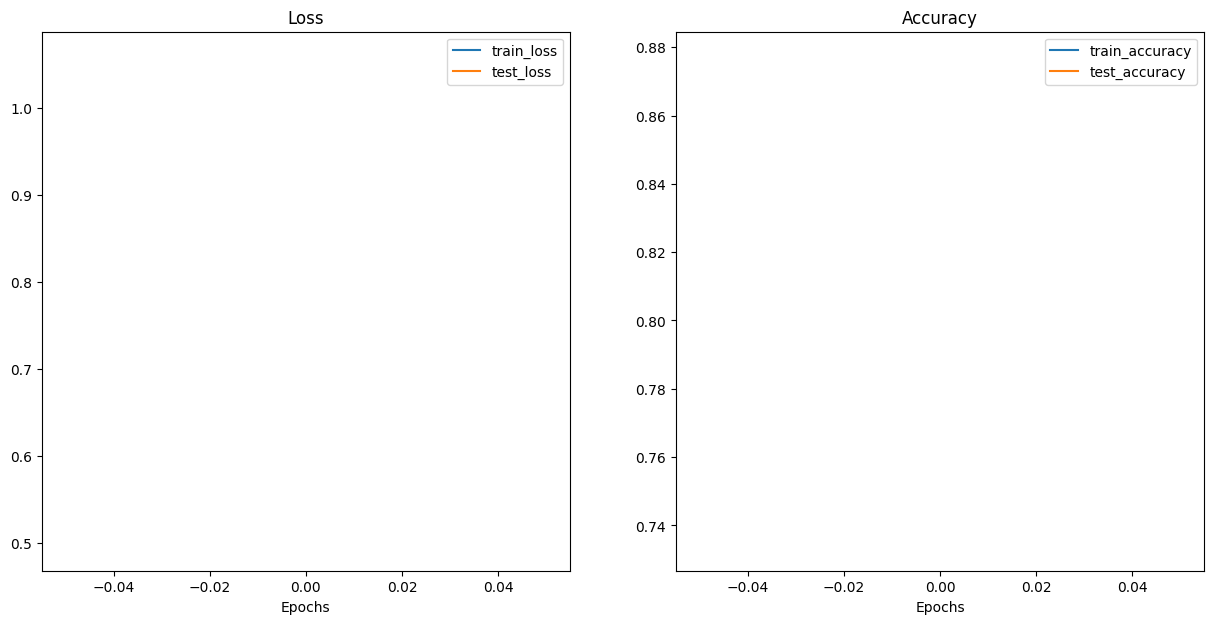

In [112]:
plot_loss_curves(model_results)

In [113]:
# model.state_dict()

### 11.8 Save and load the transfer learning model

In [114]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,
         exist_ok = True)

# Create model save
MODEL_NAME = "final_project_transfer_learning.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model.state_dict(),
      f = MODEL_SAVE_PATH)

Saving model to: models/final_project_transfer_learning.pth


In [115]:
# Create a new model instance and load the state_dict()
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
transfer_learning_loaded_model = torchvision.models.efficientnet_b0(weights = weights).to(device)
transfer_learning_loaded_model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features= len(class_names))
)
# Load in the saved state_dict()
transfer_learning_loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))
# transfer_learning_loaded_model.state_dict()

<All keys matched successfully>

## 12. Making a prediction on a custom image

In [116]:
import torchvision
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

In [117]:
def pred_and_plot_image(model: torch.nn.Module,
             image_path: str,
             class_names: List[str] = None,
             image_size: Tuple[int,int] = {224,224},
             transform: torchvision.transforms = None,
             device: torch.device = device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Open the image  
  img = Image.open(image_path) 

  # Transform if necessary
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                   std = [0.229,0.224,0.225])
    ])
  
  model.to(device)

  # Turn on eval / inference_mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # add a batch dimension
    transformed_image = image_transform(img).unsqueeze(0) # [batch_size, color_channels, height, width]  
    target_image_pred = model(transformed_image.to(device))
  
  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

  # Plot the image
  plt.figure()
  plt.imshow(img) 
  if class_names:
    title = f"Prediction: {class_names[target_image_pred_label.cpu()]} | Probability: {target_image_pred_probs.max().cpu() * 100: .3f}%"
  else:
    title = f"Prediction: {target_image_pred_label} | Probability: {target_image_pred_probs.max().cpu() * 100: .3f}%"
  plt.title(title)
  plt.axis(False)

In [118]:
custom_image_path = 'data/custom_image.jpg'

# custom_image_transform = transforms.Compose([
#     # transforms.Resize(size = (64,64))
#     transforms.Resize(size = (224,224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485,0.456,0.406],
#                std = [0.229,0.224,0.225])
# ])

# custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32) / 255

# plt.imshow(custom_image.permute(1,2,0))

# Transform target image
# custom_image_transformed = custom_image_transform(custom_image)

# print(f"Original shape: {custom_image.shape}")
# print(f"Transformed shape: {custom_image_transformed.shape}")

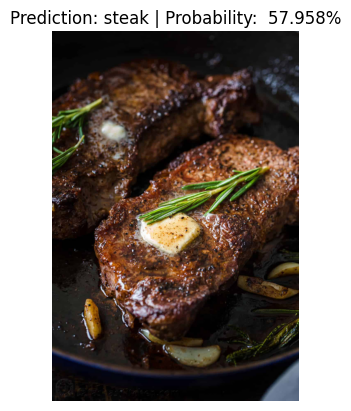

In [119]:
pred_and_plot_image(model = transfer_learning_loaded_model,
          image_path = custom_image_path,
          class_names = class_names,
          image_size = (224,224),
          device = device)